In [27]:
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
# --- Cell 1: Setup & Sanity -----------------------------------------------
import os
import json
import math
import logging
from typing import List
import numpy as np

# If you put OPENAI_API_KEY in a .env file, load it:
try:
    from dotenv import load_dotenv
    _ = load_dotenv()
except Exception:
    pass

# Basic logging (aligned with your post-4 emphasis on evaluation/logs)
logger = logging.getLogger("rag-setup")
if not logger.handlers:
    logger.setLevel(logging.INFO)
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)

def ensure_dirs(paths: List[str]) -> None:
    for p in paths:
        os.makedirs(p, exist_ok=True)

ensure_dirs(["data", "indexes", "docs"])

# Validate OpenAI key availability
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY or not OPENAI_API_KEY.strip():
    raise EnvironmentError(
        "OPENAI_API_KEY is missing. Set it via os.environ or in a .env file."
    )
logger.info("OPENAI_API_KEY detected.")

# OpenAI client (new SDK)
try:
    from openai import OpenAI
except Exception as e:
    raise RuntimeError(
        "OpenAI SDK not found. Run: pip install openai==1.*"
    ) from e

client = OpenAI()  # reads API key from env by default

EMBED_MODEL = "text-embedding-3-small"  # fast, cheap, strong baseline
logger.info(f"Embedding model set to: {EMBED_MODEL}")

def embed_texts(texts: List[str]) -> np.ndarray:
    """
    Get embeddings for a list of strings using OpenAI embeddings.
    Returns a 2D numpy array [n_texts, dim].
    """
    if not isinstance(texts, list) or not texts or not all(isinstance(t, str) and t.strip() for t in texts):
        raise ValueError("texts must be a non-empty list of non-empty strings.")
    resp = client.embeddings.create(model=EMBED_MODEL, input=texts)
    vecs = [d.embedding for d in resp.data]
    # Normalize to unit length → inner product == cosine similarity
    arr = np.array(vecs, dtype=np.float32)
    norms = np.linalg.norm(arr, axis=1, keepdims=True) + 1e-12
    return arr / norms

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Cosine similarity in [-1, 1], assuming both vectors are already normalized.
    """
    if a.ndim != 1 or b.ndim != 1 or a.shape[0] != b.shape[0]:
        raise ValueError("Inputs must be 1D vectors of the same length.")
    return float(np.dot(a, b))  # with normalized vectors, dot == cosine

logger.info("Setup helpers loaded.")


[INFO] OPENAI_API_KEY detected.
[INFO] Embedding model set to: text-embedding-3-small
[INFO] Setup helpers loaded.


In [9]:
# --- Cell 2: Embedding Smoke Test -----------------------------------------
pairs = [
    ("heart attack", "myocardial infarction"),
    ("hypertension", "high blood pressure"),
    ("antibiotic resistance", "bacteria resistant to antibiotics"),
    ("diabetes", "type 2 diabetes"),
    ("appendix", "banana")  # control: unrelated terms
]

left = [p[0] for p in pairs]
right = [p[1] for p in pairs]

# Embed both sides
L = embed_texts(left)
R = embed_texts(right)

# Compute pairwise cosine
sims = [cosine_similarity(L[i], R[i]) for i in range(len(pairs))]

results = [
    {"pair": pairs[i], "cosine_similarity": round(sims[i], 3)}
    for i in range(len(pairs))
]

print(json.dumps(results, indent=2))


[
  {
    "pair": [
      "heart attack",
      "myocardial infarction"
    ],
    "cosine_similarity": 0.591
  },
  {
    "pair": [
      "hypertension",
      "high blood pressure"
    ],
    "cosine_similarity": 0.783
  },
  {
    "pair": [
      "antibiotic resistance",
      "bacteria resistant to antibiotics"
    ],
    "cosine_similarity": 0.734
  },
  {
    "pair": [
      "diabetes",
      "type 2 diabetes"
    ],
    "cosine_similarity": 0.715
  },
  {
    "pair": [
      "appendix",
      "banana"
    ],
    "cosine_similarity": 0.257
  }
]


In [13]:
# --- Cell 3: Fetch PubMed Data ---------------------------------------------
from Bio import Entrez
import pandas as pd
from tqdm import tqdm
import time

# Configure Entrez (PubMed API)
Entrez.email = "your_email@example.com"  # required by NCBI, any valid email
SEARCH_TERMS = ["antimicrobial resistance", "hypertension"]  # you can change topics
MAX_RESULTS_PER_TERM = 120   # ~240 total (adjustable)

def fetch_pubmed_abstracts(term: str, max_results: int = 100):
    """Search PubMed and return a list of (title, abstract, url)."""
    logger.info(f"Fetching PubMed abstracts for: {term}")
    handle = Entrez.esearch(db="pubmed", term=term, retmax=max_results)
    record = Entrez.read(handle)
    ids = record["IdList"]
    results = []

    for pmid in tqdm(ids, desc=f"Downloading {term}", ncols=80):
        try:
            fetch = Entrez.efetch(db="pubmed", id=pmid, rettype="abstract", retmode="xml")
            paper = Entrez.read(fetch)
            art = paper["PubmedArticle"][0]["MedlineCitation"]["Article"]
            title = art.get("ArticleTitle", "")
            abstract = " ".join([a for a in art.get("Abstract", {}).get("AbstractText", [])])
            url = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"
            if title and abstract:
                results.append({"title": title.strip(),
                                "abstract": abstract.strip(),
                                "url": url})
            time.sleep(0.1)  # be polite to NCBI servers
        except Exception as e:
            logger.warning(f"Skipped {pmid}: {e}")
    return results

# Run for both terms
all_records = []
for term in SEARCH_TERMS:
    all_records.extend(fetch_pubmed_abstracts(term, MAX_RESULTS_PER_TERM))

df = pd.DataFrame(all_records)
logger.info(f"Fetched {len(df)} total abstracts.")

os.makedirs("data", exist_ok=True)
df.to_csv("data/pubmed_corpus.csv", index=False)
logger.info("Saved → data/pubmed_corpus.csv")

df.head(5)


[INFO] Fetching PubMed abstracts for: antimicrobial resistance
[INFO] Fetching PubMed abstracts for: hypertension
[INFO] Fetched 233 total abstracts.
[INFO] Saved → data/pubmed_corpus.csv


,title,abstract,url
0,Global susceptibility profiles and potential r...,A total of 2361 ceftazidime-avibactam-resistan...,https://pubmed.ncbi.nlm.nih.gov/41054939/
1,Advances in Isothermal Amplification for the D...,Detecting tuberculosis (TB) remains challengin...,https://pubmed.ncbi.nlm.nih.gov/41054873/
2,Amoxicillin/clavulanate as a cornerstone of an...,Antimicrobial resistance (AMR) remains a criti...,https://pubmed.ncbi.nlm.nih.gov/41054784/
3,Laboratory evaluation of 185 commercial assays...,"In August 2020, Public Health England and Oxfo...",https://pubmed.ncbi.nlm.nih.gov/41054442/
4,Evaluation of SARS-CoV-2 lateral flow device s...,Self-testing for SARS-CoV-2 infection using la...,https://pubmed.ncbi.nlm.nih.gov/41054440/


In [21]:
# --- Cell 4: Chunk + Embed + Build FAISS Index ------------------------------
import faiss
import numpy as np
import json
from tqdm import tqdm

# Load the abstracts
df = pd.read_csv("data/pubmed_corpus.csv")
logger.info(f"Loaded {len(df)} abstracts for chunking.")

CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200

def chunk_text(text: str, size: int = CHUNK_SIZE, overlap: int = CHUNK_OVERLAP):
    """Split text into overlapping chunks (character-level)."""
    chunks = []
    start = 0
    while start < len(text):
        end = start + size
        chunk = text[start:end]
        chunks.append(chunk)
        start += size - overlap
        if start >= len(text):
            break
    return chunks

# Build list of chunks with metadata
records = []
for i, row in tqdm(df.iterrows(), total=len(df), ncols=80, desc="Chunking"):
    for chunk in chunk_text(row["abstract"]):
        records.append({
            "title": row["title"],
            "text": chunk,
            "url": row["url"]
        })

logger.info(f"Total chunks created: {len(records)}")

# Get embeddings (OpenAI)
texts = [r["text"] for r in records]
logger.info("Embedding all chunks (this may take a minute)...")
BATCH = 50
vecs = []

for i in tqdm(range(0, len(texts), BATCH), ncols=80, desc="Embedding"):
    batch = texts[i:i+BATCH]
    resp = client.embeddings.create(model="text-embedding-3-small", input=batch)
    batch_vecs = [d.embedding for d in resp.data]
    vecs.extend(batch_vecs)

embeddings = np.array(vecs, dtype="float32")
# Normalize for cosine similarity
embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)

# Build FAISS index
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)

os.makedirs("indexes", exist_ok=True)
faiss.write_index(index, "indexes/pubmed.index")

with open("indexes/corpus.json", "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

logger.info("FAISS index + corpus metadata saved.")


[INFO] Loaded 233 abstracts for chunking.
Chunking: 100%|████████████████████████████| 233/233 [00:00<00:00, 30041.28it/s]
[INFO] Total chunks created: 636
[INFO] Embedding all chunks (this may take a minute)...
Embedding: 100%|████████████████████████████████| 13/13 [00:18<00:00,  1.44s/it]
[INFO] FAISS index + corpus metadata saved.


In [23]:
print(index.ntotal)
print(len(records))


636
636


In [25]:
# --- Cell 5: Retrieval + Answer Generation -----------------------------------
from openai import OpenAI

client = OpenAI()

# Load FAISS + corpus
index = faiss.read_index("indexes/pubmed.index")
with open("indexes/corpus.json", "r", encoding="utf-8") as f:
    corpus = json.load(f)

def retrieve_top_k(question: str, k: int = 3):
    """Retrieve top-k chunks for a question."""
    q_vec = client.embeddings.create(model="text-embedding-3-small", input=[question]).data[0].embedding
    q_vec = np.array(q_vec, dtype="float32")
    q_vec /= np.linalg.norm(q_vec)
    scores, idxs = index.search(q_vec.reshape(1, -1), k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        results.append({
            "score": float(score),
            "title": corpus[idx]["title"],
            "text": corpus[idx]["text"],
            "url": corpus[idx]["url"]
        })
    return results

def build_prompt(question: str, contexts: list[dict]):
    """Build a structured RAG prompt with clear boundaries + citation requirement."""
    context_texts = []
    for i, ctx in enumerate(contexts, start=1):
        context_texts.append(f"[Source {i}] {ctx['text']}\n(Citation: {ctx['url']})")
    joined_context = "\n\n".join(context_texts)
    prompt = f"""
You are a medical research assistant.
Use ONLY the following retrieved context to answer the question.
If the answer cannot be found, say "Not enough information in the retrieved papers."

Question: {question}

Retrieved Context:
{joined_context}

Instructions:
1. Answer concisely and factually.
2. Cite sources by [Source #].
3. Do not include information not in the context.
"""
    return prompt.strip()

def generate_answer(question: str, k: int = 3, model: str = "gpt-4o-mini"):
    """Full RAG pipeline: retrieve, prompt, generate."""
    hits = retrieve_top_k(question, k=k)
    prompt = build_prompt(question, hits)
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3
    )
    answer = response.choices[0].message.content
    quality = round(np.mean([h["score"] for h in hits]), 3)
    citations = [{"title": h["title"], "url": h["url"], "score": round(h["score"], 3)} for h in hits]
    result = {
        "question": question,
        "answer": answer,
        "quality": quality,
        "citations": citations
    }
    return result

# Example query
query = "What are current challenges in combating antimicrobial resistance?"
result = generate_answer(query, k=3)

from pprint import pprint
pprint(result)


{'answer': 'Current challenges in combating antimicrobial resistance (AMR) '
           'include the rapid emergence of multidrug-resistant (MDR) and '
           'extensively drug-resistant (XDR) pathogens, which threaten modern '
           'medical procedures such as surgery and chemotherapy. Conventional '
           'antibiotics are increasingly limited due to mechanisms like '
           'target-site mutations, efflux mechanisms, enzymatic degradation, '
           'and biofilm-associated tolerance. Additionally, inappropriate '
           'antimicrobial use accelerates AMR, creating tensions between '
           'antimicrobial stewardship and timely treatment. There are also '
           'systemic factors that contribute to gaps between recommendations '
           'and actual clinical practice [Source 1][Source 2]. Furthermore, '
           'global surveillance has shown a shift in infections from '
           'staphylococcal dominance to multidrug-resistant Gram-negative '
   

Total queries logged: 1
Average quality score: 0.584


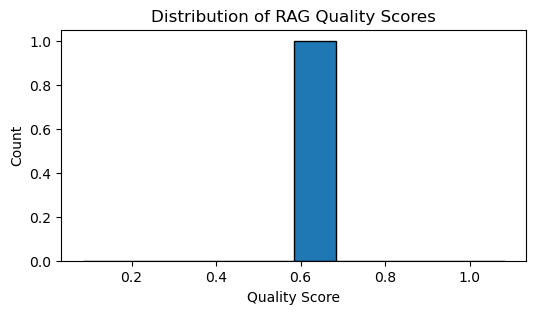

In [29]:
# --- eval_dashboard.py (optional quick analysis) -----------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("logs/chat_history.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

print("Total queries logged:", len(df))
print("Average quality score:", round(df["quality"].mean(), 3))

plt.figure(figsize=(6,3))
plt.hist(df["quality"], bins=10, edgecolor="black")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.title("Distribution of RAG Quality Scores")
plt.show()


## Hybrid RAG Extension — OCR + E5 + Chroma

In [4]:
# Run once; ignore "already satisfied" messages.
%pip install --quiet paddleocr "paddlepaddle==2.6.1" chromadb sentence-transformers pymupdf langchain pillow numpy


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.28.0 requires protobuf<5,>=3.20, but you have protobuf 6.32.1 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.32.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
